In [ ]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV

In [2]:
city = 'Bhopal'
month = 'July'
PATH = f'./../Item_wise_data/{city}/'
# PATH = './../'


In [ ]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(156415, 29)
(156415, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(156415, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(156186, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [7]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

146
12


In [8]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [9]:
def get_preparation_time(item):
    return item['prep_time']

In [10]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [11]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [12]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [13]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [15]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [16]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [17]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [19]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [20]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/294207109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/294207109.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/294207109.py:8: SettingWithCopyWarning: 
A va

In [21]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [22]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1

    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/3148041664.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/3148041664.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/var/folders/44/wjytndj97cq3yq4r22tkb6t00000gn/T/ipykernel_5000/3148041664.py:23: SettingWithCopyWarning: 
A value is trying to be set on 

In [24]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [25]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [26]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [27]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [29]:
lengthQueue(sampleItem)

2

In [31]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'xgboost'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [32]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [33]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [34]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                1 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                1 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [35]:
def updateFeatures(storeId, Xnp):
    restWiseDFs[storeId][feature_cols] = Xnp

In [36]:
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
        features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

(16460, 11)
(10763, 11)
(18798, 11)
(14284, 11)
(11443, 11)
(12344, 11)
(17184, 11)
(9330, 11)
(10509, 11)
(12105, 11)
(12230, 11)
(10736, 11)


In [37]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

In [40]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [41]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [37]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21) + timedelta(days=1)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] < lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 23) + timedelta(days=1)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 31) + timedelta(days=1)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    overallPredictions = best_regressor.predict(overallDF[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions


    print("ACCURACY ON TRAINING DATA : ")

    for storeId in allStoreIds:
        restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = restWiseDFs[storeId]['predicted_prep_time_central']
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", getRMSE(y, predictions))

Best hyperparameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7, 'tree_method': 'approx'}
Best mean cross-validated score: 0.24136717140391878
Test score: 0.2603012284709243
RMSE score overall for store central model (30 days) DPI66168 :   119.79152563921313
RMSE score overall for store central model (30 days) DPI65804 :   148.95013614111664
RMSE score overall for store central model (30 days) DPI65767 :   113.84408161835557
RMSE score overall for store central model (30 days) DPI67065 :   143.68797700704354
RMSE score overall for store central model (30 days) DPI65762 :   153.24295598692373
RMSE score overall for store central model (30 days) DPI67060 :   147.411927663573
RMSE score overall for store central model (30 days) DPI63887 :   116.9352554002776
RMSE score overall for store central model (30 days) DPI65924 :   106.9082556464444
RMSE score overall for store central model (30 days) DPI66466 :

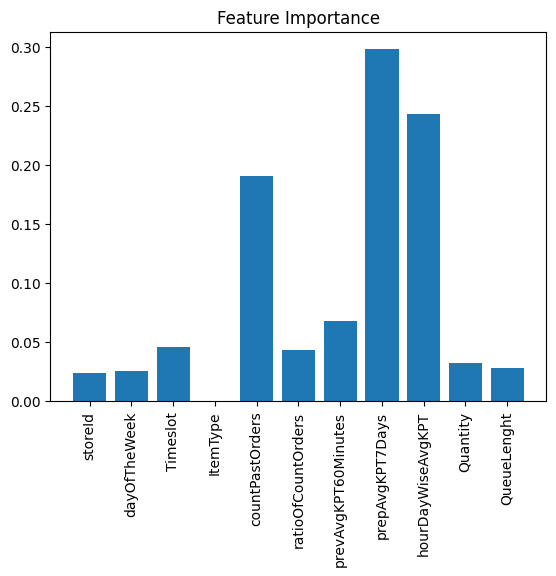

1.000000037252903


In [38]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [39]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

(17459, 7)
(30646, 7)
(32158, 7)
(16038, 7)
(26507, 7)
(21103, 7)
(17783, 7)
(18224, 7)
(30588, 7)
(21039, 7)
(20658, 7)
(14800, 7)
(18898, 7)
(31135, 7)
(13885, 7)
(22893, 7)
(18355, 7)
(20968, 7)
(16024, 7)
(25102, 7)
(17596, 7)
(10249, 7)
(28368, 7)
(11231, 7)
(28199, 7)
(16463, 7)
(24379, 7)
(15482, 7)
(19083, 7)
(27703, 7)
(16751, 7)
(18627, 7)
(26682, 7)
(24945, 7)
(17472, 7)
(29015, 7)
(20893, 7)
(26173, 7)
(18796, 7)
(25838, 7)
(12622, 7)
(14158, 7)
(9561, 7)
(23145, 7)
(19613, 7)
(21952, 7)
(19793, 7)
(3739, 7)
(21859, 7)
(17453, 7)
(7113, 7)
(22746, 7)
(9251, 7)
(18577, 7)
(18701, 7)
(23314, 7)
(21335, 7)
(11436, 7)
(5683, 7)
(19544, 7)
(16394, 7)
(19644, 7)
(9177, 7)
(25712, 7)
(14860, 7)
(16748, 7)
(29494, 7)
(12595, 7)
(16824, 7)
(19854, 7)
(24367, 7)
(19503, 7)
(23018, 7)
(25389, 7)
(19968, 7)
(13566, 7)
(30404, 7)
(7924, 7)
(13604, 7)
(26722, 7)
(19332, 7)
(16561, 7)
(14665, 7)
(19654, 7)
(28859, 7)
(5498, 7)
(26249, 7)
(31039, 7)
(30907, 7)
(13153, 7)
(11093, 7)
(19033,

In [40]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [41]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

(111.74294178264128,
 116.78776877486361,
 85.75041728579787,
 88.11095616598246,
 70.18222506713867,
 70.61465470607013)

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

Best hyperparameters: {'colsample_bytree': 0.6, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8, 'tree_method': 'approx'}
Best mean cross-validated score: 0.23354428656187967
[15:59:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:59:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:59:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:59:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:59:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:feature_2: category

In [42]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

NameError: name 'testingData' is not defined

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)